In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBClassifier
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score
import shap

In [2]:
# Load data
data = pd.read_csv("data_2002_2024.csv")
data

,team,season,week,total_yards,def_yards_allowed,turnovers,possession_time,pass_yards,rush_yards,third_down_pct,redzone_pct,point_diff,ypp,result,is_champion
0,49ers,2002,17,329,263,2,2137,136,193,0.428571,0.000000,-11,5.222222,0,0
1,49ers,2002,16,358,184,2,2059,252,106,0.550000,0.000000,3,4.904110,1,0
2,49ers,2002,15,263,302,1,1437,156,107,0.461538,0.000000,-6,4.614035,0,0
3,49ers,2002,14,401,257,1,2159,276,125,0.500000,0.000000,4,4.717647,1,0
4,49ers,2002,13,299,507,2,1945,157,142,0.562500,0.000000,7,4.397059,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7355,Vikings,2024,13,273,406,1,1451,205,68,0.125000,0.500000,1,5.352941,1,0
7356,Vikings,2024,12,452,398,1,2006,328,124,0.461538,0.428571,3,6.953846,1,0
7357,Vikings,2024,11,318,294,1,1951,236,82,0.357143,1.000000,10,4.746269,1,0
7358,Vikings,2024,10,402,143,3,2539,233,169,0.357143,0.000000,5,4.902439,1,0


In [3]:
# Load dicts
with open("playoff_dict.json") as f:
    playoff_dict = json.load(f)
playoff_dict = {int(k): v for k, v in playoff_dict.items()}

with open("finalists_dict.json") as f:
    finalists_dict = json.load(f)
finalists_dict = {int(k): v for k, v in finalists_dict.items()}

with open("champions_dict.json") as f:
    champions_dict = json.load(f)
champions_dict = {int(k): v for k, v in champions_dict.items()}

with open("division_winners_dict.json") as f:
    division_winners_dict = json.load(f)
division_winners_dict = {int(k): v for k, v in division_winners_dict.items()}

In [4]:
# Function to get training data
def get_training_data(data, season, year_back, playoff_dict):
    # Select data from past seasons within the training window size
    train = data[(data["season"] < season) & (data["season"] >= (season - year_back))]

    # Filter for playoff teams
    train = train[train.apply(lambda row: row["team"] in playoff_dict.get(row["season"], []), axis=1)]
    
    # Separate features (X) and labels (y)
    X_train = train.drop(columns=["team", "season", "week", "result", "is_champion"])
    y_train = train["is_champion"]
    
    return X_train, y_train


# Function to train an XGBoost model
def train_model(X_train, y_train):
    # Initialise model
    model = XGBClassifier(eval_metric="logloss", random_state=42)

    # Train model
    model.fit(X_train, y_train)
    
    return model


# Function to get season data for prediction
def get_season_data(data, season, finalists_dict):
    # Select data for the tatget season
    season_data = data[data["season"] == season]

    # Filter for finalist teams
    season_data = season_data[season_data.apply(lambda row: row["team"] in finalists_dict.get(row["season"], []), axis=1)]

    # Keep only the last 4 weeks of the season
    season_data = season_data[season_data["week"] >= season_data["week"].max() - 3]
    
    return season_data.reset_index(drop=True)


# Function to predict, rank, and evaluate predictions for a season
def predict_and_evaluate(model, season_data, season, year):
    # Prepare features for prediction
    X_season = season_data.drop(columns=["team", "season", "week", "result", "is_champion"])
    
    # Predict championship probabilities
    probs = model.predict_proba(X_season)[:, 1]

    # Prepare ranking dataframe
    ranked = season_data[["team"]].copy()
    ranked["prob"] = probs
    ranked["is_champion"] = season_data["is_champion"]

    # Average probabilities per team
    ranked = ranked.groupby(["team", "is_champion"])["prob"].mean().reset_index()

    # Sort teams by predicted probability
    ranked = ranked.sort_values("prob", ascending=False).reset_index(drop=True)
    
    return {
        "superbowl_year": season,
        "n_seasons_history": year,
        "model_pick_team": ranked.iloc[0]["team"],  # Team selected by model
        "model_pick_prob": ranked.iloc[0]["prob"] / (ranked.iloc[0]["prob"] + ranked.iloc[1]["prob"]),  # Relative probability of top team
        "is_prediction_correct": ranked.iloc[0]["is_champion"] == 1,  # Whether prediction was correct
        "other_team": ranked.iloc[1]["team"],  # Second team
        "other_team_prob": ranked.iloc[1]["prob"] / (ranked.iloc[0]["prob"] + ranked.iloc[1]["prob"]),  # Relative probability of second team
        "champion_team": ranked[ranked["is_champion"] == 1]["team"].iloc[0],  # Actual champion team
        "true_prob": ranked[ranked["is_champion"] == 1]["prob"].iloc[0]/ (ranked.iloc[0]["prob"] + ranked.iloc[1]["prob"]),  # Actual champion probability
    }


# Main function to evaluate model over multiple historical periods and seasons
def evaluate_all_year_backs(data, playoff_dict, finalists_dict):
    all_results = []       # Store detailed results
    trained_models = {}    # Store trained models

    # Loop through each history window
    for year_back in [1, 2, 3, 4, 7, 10, 12]:
        results = []

        # Evaluate for each season
        for season in range(2019,2025):
            # Get training data
            X_train, y_train = get_training_data(data, season, year_back, playoff_dict)

            # Train model
            model = train_model(X_train, y_train)
            trained_models[(year_back, season)] = model

            # Prepare test data and evaluate
            season_data = get_season_data(data, season, finalists_dict)
            result = predict_and_evaluate(model, season_data, season, year_back)
            results.append(result)

        # Append season results to overall results
        all_results.extend(results)

    return pd.DataFrame(all_results), trained_models

all_results, models = evaluate_all_year_backs(data, playoff_dict, finalists_dict)

In [5]:
def evaluate_model(df):
    df = df.copy()

    # Calculate true probability for the actual champion team
    df['true_prob'] = np.where(df['is_prediction_correct'], df['model_pick_prob'], df['other_team_prob'])

    # Prepare data for AUC calculation
    winners = pd.DataFrame({
        'n_seasons_history': df['n_seasons_history'],
        'is_winner': 1,
        'prob': df['true_prob']
    })

    # Determine losing team probabilities
    mask = df['champion_team'] == df['model_pick_team']
    loser_probs = np.where(mask, df['other_team_prob'], df['model_pick_prob'])

    losers = pd.DataFrame({
        'n_seasons_history': df['n_seasons_history'],
        'is_winner': 0,
        'prob': loser_probs
    })
    
    # Combine winners and losers
    df_auc = pd.concat([winners, losers], ignore_index=True)

    # Calculate metrics by history window
    grouped = df.groupby('n_seasons_history')
    auc_grouped = df_auc.groupby('n_seasons_history')

    metrics_by_window = pd.DataFrame({
        'accuracy': grouped['is_prediction_correct'].mean(),
        'auc': auc_grouped.apply(lambda g: roc_auc_score(g['is_winner'], g['prob'])),
        'logloss': grouped.apply(lambda g: log_loss(np.ones(len(g)), g['true_prob'], labels=[0, 1])),
        'brier': grouped.apply(lambda g: brier_score_loss(np.ones(len(g)), g['true_prob']))
    }).reset_index()

    return metrics_by_window

by_window = evaluate_model(all_results)

print("\nMetrics per window:")
by_window.round(4)


Metrics per window:


,n_seasons_history,accuracy,auc,logloss,brier
0,1,0.6667,0.7778,0.6200,0.2310
1,2,1.0000,1.0000,0.2216,0.0430
2,3,0.8333,0.7500,0.6281,0.2135
3,4,0.5000,0.2500,1.2651,0.4347
4,7,0.5000,0.4167,1.1596,0.3799
5,10,0.6667,0.7778,0.6432,0.2211
6,12,0.5000,0.6389,0.7218,0.2677


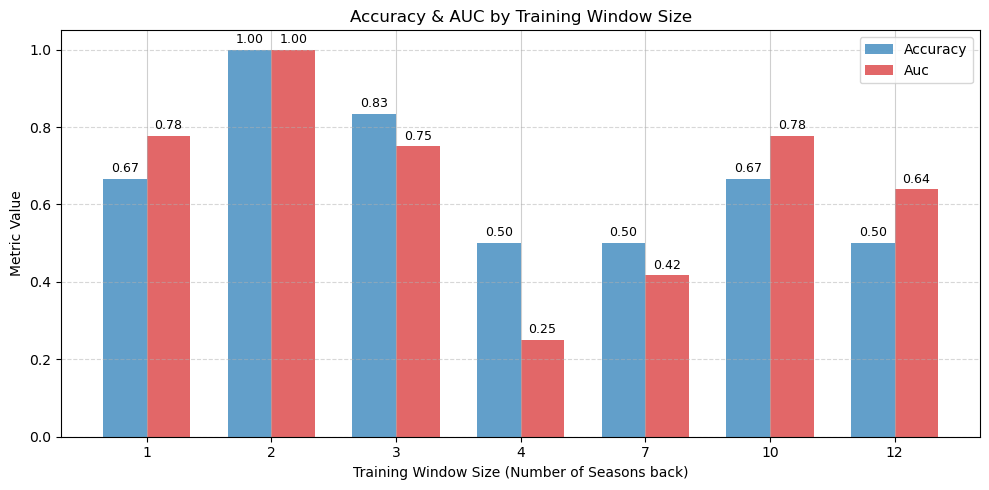

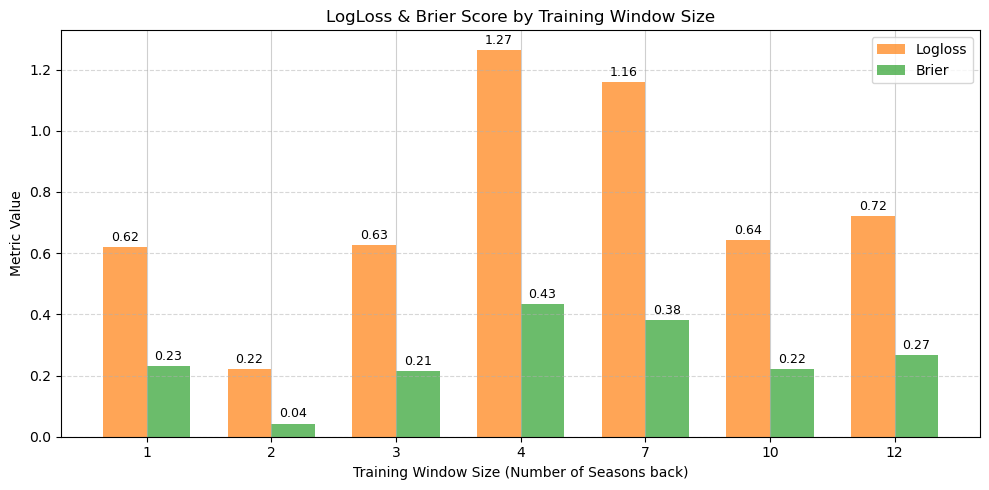

In [6]:
def plot_metrics_by_window(by_window):
    # Define metric groups and colors
    metrics_groups = [
        (['accuracy', 'auc'], 'Accuracy & AUC'),
        (['logloss', 'brier'], 'LogLoss & Brier Score')
    ]
    colors = {
        'accuracy': 'tab:blue',
        'auc': 'tab:red',
        'logloss': 'tab:orange',
        'brier': 'tab:green'
    }

    # X-axis setup
    windows = by_window['n_seasons_history']
    x = np.arange(len(windows))
    bar_width = 0.35  # For 2 bars per group

    # Create plots
    for group_metrics, title in metrics_groups:
        plt.figure(figsize=(10, 5))

        for i, metric in enumerate(group_metrics):
            offset = i * bar_width
            bar_x = x + offset
            values = by_window[metric]

            # Plot bars
            plt.bar(bar_x, values, width=bar_width, label=metric.capitalize(), color=colors[metric], alpha=0.7)

            # Value labels
            for x_pos, val in zip(bar_x, values):
                plt.text(x_pos, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9)

        # Axis and grid settings
        plt.xticks(x + bar_width * 0.5, windows)
        plt.xlabel('Training Window Size (Number of Seasons back)')
        plt.ylabel('Metric Value')
        plt.title(f'{title} by Training Window Size')
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.grid(axis='x', linestyle='-', alpha=0.6)
        plt.tight_layout()
        plt.show()

plot_metrics_by_window(by_window)

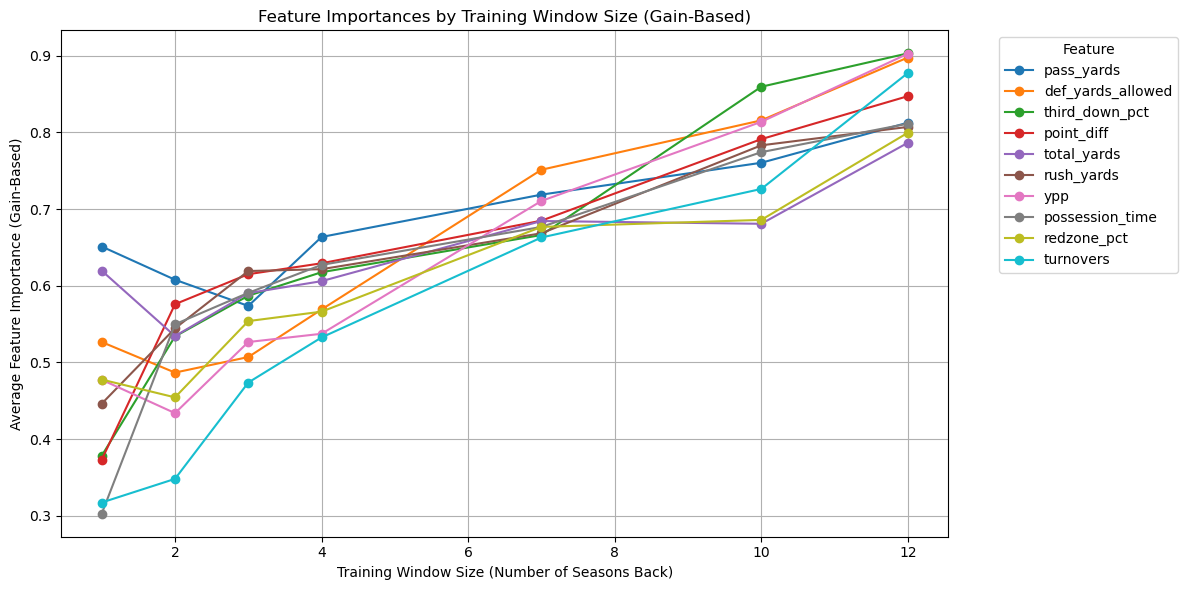

In [7]:
# Plots the average feature importances of XGBoost models across different training window sizes
def plot_feature_importances(models):
    # List of feature names used in the models
    feature_names = ["total_yards", "def_yards_allowed", "turnovers", "possession_time", "pass_yards", "rush_yards", "third_down_pct", "redzone_pct", "point_diff", "ypp"]

    # Collect feature importances from each model
    rows = []
    for (year_back, season), model in models.items():
        booster = model.get_booster()
        # Get feature importances based on 'gain'
        score_dict = booster.get_score(importance_type='gain')

        # Build row: include 0.0 for features not used in splits
        row = {"year_back": year_back}
        for f in feature_names:
            row[f] = score_dict.get(f, 0.0)
        rows.append(row)

    # Create DataFrame from all rows
    df = pd.DataFrame(rows)

    # Calculate average feature importance per training window size
    avg_df = df.groupby("year_back").mean(numeric_only=True)

    # Sort features by overall average importance (descending)
    mean_importance = avg_df.mean(axis=0).sort_values(ascending=False)
    avg_df = avg_df[mean_importance.index]

    # Plot feature importances as line plots
    plt.figure(figsize=(12, 6))
    for feature in avg_df.columns:
        plt.plot(avg_df.index, avg_df[feature], marker='o', label=feature)

    # Plot formatting
    plt.title("Feature Importances by Training Window Size (Gain-Based)")
    plt.xlabel("Training Window Size (Number of Seasons Back)")
    plt.ylabel("Average Feature Importance (Gain-Based)")
    plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_feature_importances(models)

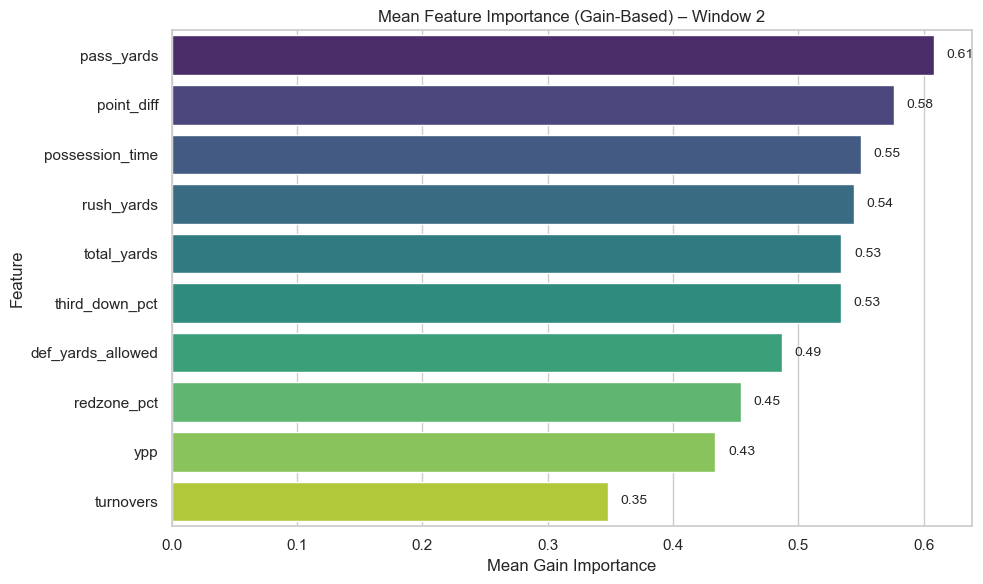

In [8]:
# Plots the mean feature importance for all models trained with a specific window size
def plot_window_feature_importance(models, window):

    # Collect feature importances for the specified window
    rows = []
    for (year_back, season), model in models.items():
        if year_back != window:
            continue
        booster = model.get_booster()
        importance_dict = booster.get_score(importance_type='gain')

        # Store feature importances
        for feature_name, importance in importance_dict.items():
            rows.append({
                'window': window,
                'season': season,
                'feature': feature_name,
                'importance': importance
            })

    # Create DataFrame of importances
    df = pd.DataFrame(rows)

    # Calculate mean importance per feature
    mean_imp = (df.groupby('feature')['importance'].mean().sort_values(ascending=False))

    # Plot barplot
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("viridis", len(mean_imp))
    sns.set(style="whitegrid")
    ax = sns.barplot(x=mean_imp.values, y=mean_imp.index, palette=colors)

    # Add value labels
    for i, (val, label) in enumerate(zip(mean_imp.values, mean_imp.index)):
        ax.text(val + 0.01, i, f"{val:.2f}", va='center', fontsize=10)

    plt.title(f'Mean Feature Importance (Gain-Based) – Window {window}')
    plt.xlabel('Mean Gain Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

plot_window_feature_importance(models, window=2)

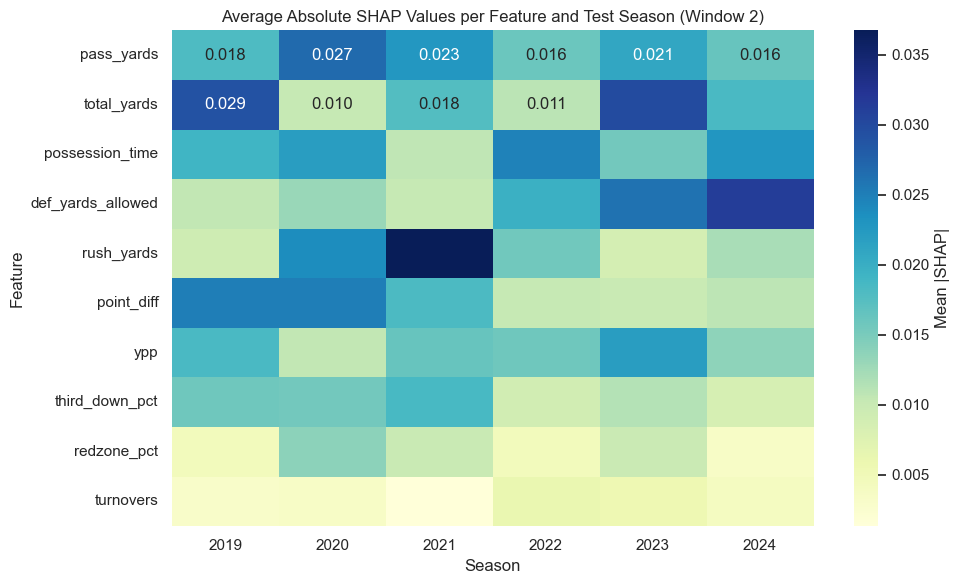

In [9]:
def plot_shap_heatmap(models, data, playoff_dict, window):

    rows = []

    # Get list of seasons that were evaluated with the selected window size
    seasons_for_window = [season for (w, season) in models if w == window]

    # Loop over each season
    for season in seasons_for_window:
        # Retrieve the model for this specific window and season
        model = models[(window, season)]
        
        # Get the training data used for this season
        X_train, y_train = get_training_data(data, season, window, playoff_dict)

        # Create SHAP explainer for the model
        explainer = shap.Explainer(model, X_train, model_output="probability")
        # Compute SHAP values for all training samples
        shap_values = explainer(X_train)

        # Compute mean absolute SHAP values for each feature across all samples
        shap_array = np.abs(shap_values.values).mean(axis=0)
        feature_names = X_train.columns

        # Store feature importance data for this season
        for feature, value in zip(feature_names, shap_array):
            rows.append({
                'season': season,
                'feature': feature,
                'mean_abs_shap': value
            })

    # Create dataframe from results
    df_shap = pd.DataFrame(rows)

    # Create pivot table: features x seasons
    shap_matrix = df_shap.pivot(index='season', columns='feature', values='mean_abs_shap').fillna(0)

    # Sort features by overall mean importance
    sorted_features = shap_matrix.mean().sort_values(ascending=False).index
    shap_matrix = shap_matrix[sorted_features]
    
    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(shap_matrix.T, annot=True, fmt=".3f", cmap='YlGnBu', cbar_kws={'label': 'Mean |SHAP|'})
    plt.title(f'Average Absolute SHAP Values per Feature and Test Season (Window {window})')
    plt.xlabel('Season')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    return shap_matrix

df_shap = plot_shap_heatmap(models, data, playoff_dict, window=2)

### Export Results and Model for Case Study 2024

This optional cell exports the full prediction results and the trained model for window size = 2 in season 2024.  
The exported results are used later in the case study notebook to analyse the 2024 season predictions.

In [10]:
# OPTIONAL: Uncomment to export results
if False:
    # Save prediction results
    all_results.to_csv("scenario1_predictions.csv")

    # Save trained model for window size = 2, season = 2024
    model = models[(2, 2024)]
    model.save_model("model_scenario1_2024_window2.json")